In [20]:
# 1. 导入依赖
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')
from viz_utils import plot_group_bar
from stats_utils import t_test
import matplotlib
import matplotlib.pyplot as plt
# 设置中文字体（SimHei 是黑体）
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
matplotlib.rcParams['axes.unicode_minus'] = False    # 正确显示负号



# 2. 读取数据
df = pd.read_csv('../data/processed/merged_data.csv')
df.head()

,title,play_count,date,duration,tname,tname_v2,view,reply,favorite,coin,share,like,dislike,tags,duration_seconds
0,我们最早去探明日方舟联名店但是最晚发…,581000.0,2025-5-5,13:31,搞笑,二次元线下,581916,1068,6238,10496,6399,44425,0,明日方舟 名创优品 联动,811
1,我们从网上找来了一些有趣网站…,822000.0,2025-5-3,23:08,搞笑,随拍·综合,822231,1031,15459,29698,2448,63762,0,解锁一个新兴趣 有趣 搞笑 娱乐 吐槽 电脑 把兴趣玩出名堂 互联网 网站,1388
2,谢谢你影石insta360 X5 全景相机让我们又有理由出去玩了…,307000.0,2025-5-1,15:56,搞笑,摄影摄像,307463,485,2369,5575,580,17513,0,拍照设备 影石X5 运动相机,956
3,就是因为你才没刮胡子么飞科？,486000.0,2025-4-28,03:25,搞笑,家用电器,486010,724,2034,4311,348,28489,0,飞科f8 飞科f8剃须刀 飞科f8往复式便携剃须刀,205
4,又网买玩...,1077000.0,2025-4-25,41:52,搞笑,潮玩玩具,1077579,2029,10178,25748,1938,55510,0,开箱,2512


In [5]:
# 3. 计算互动率
df['like_rate'] = df['like'] / df['view'].replace(0, np.nan)
df['favorite_rate'] = df['favorite'] / df['view'].replace(0, np.nan)
df['coin_rate'] = df['coin'] / df['view'].replace(0, np.nan)
df['share_rate'] = df['share'] / df['view'].replace(0, np.nan)
df['reply_rate'] = df['reply'] / df['view'].replace(0, np.nan)
df['all_interact_rate'] = (df['like'] + df['favorite'] + df['coin'] + df['share'] + df['reply']) / df['view'].replace(0, np.nan)
df[['like_rate', 'favorite_rate', 'coin_rate', 'share_rate', 'reply_rate', 'all_interact_rate']].describe()

,like_rate,favorite_rate,coin_rate,share_rate,reply_rate,all_interact_rate
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,0.051181,0.005631,0.016343,0.002865,0.001498,0.077518
std,0.014706,0.004094,0.014223,0.002605,0.001606,0.031945
min,0.021996,0.001258,0.002221,0.000206,0.000200,0.028997
25%,0.039257,0.003120,0.008151,0.001236,0.000788,0.054756
50%,0.051404,0.004596,0.012072,0.002062,0.001151,0.074032
75%,0.060278,0.006966,0.019792,0.003500,0.001720,0.091304
max,0.110510,0.045035,0.149473,0.020692,0.017884,0.302805


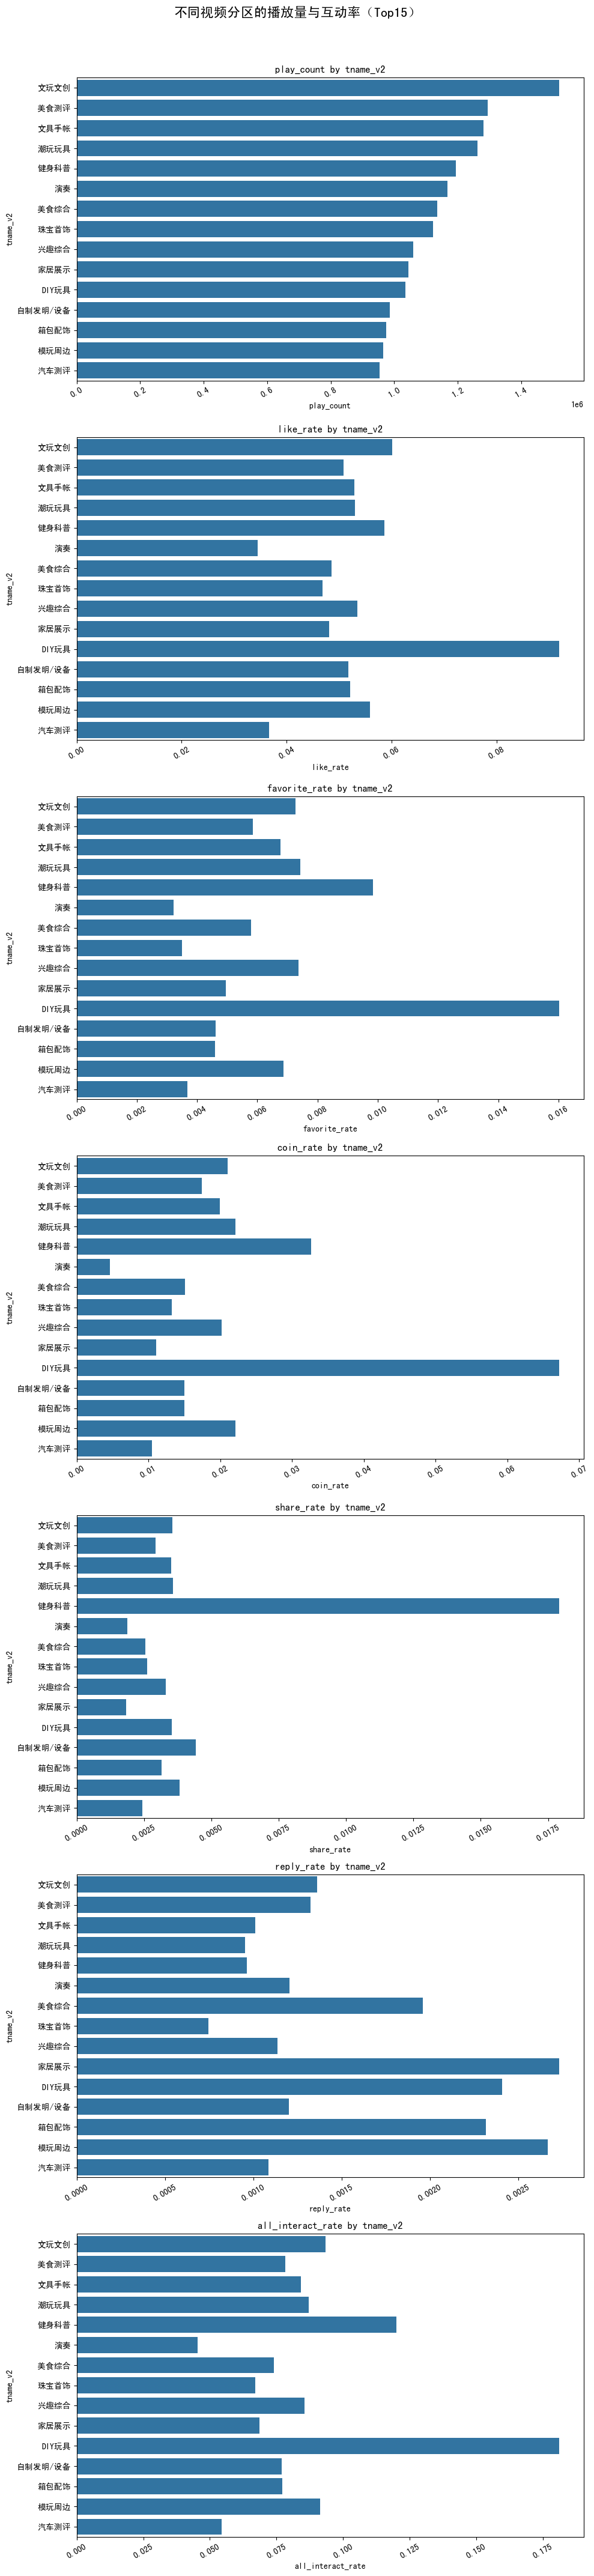

In [7]:
# 4. 分组可视化
# 只展示播放量最高的前15个分区，横向分面柱状图
group_cols = ['play_count', 'like_rate', 'favorite_rate', 'coin_rate', 'share_rate', 'reply_rate', 'all_interact_rate']
plot_group_bar(
    df, 
    'tname_v2', 
    group_cols, 
    title='不同视频分区的播放量与互动率（Top15）', 
    ylabel='分区', 
    top_n=15, 
    horizontal=True, 
    facet=True
)

In [9]:
# 5. 高流量组 vs 低流量组 T 检验
median_play = df['play_count'].median()
high_group = df[df['play_count'] >= median_play]
low_group = df[df['play_count'] < median_play]
results = {}
for col in ['like_rate', 'favorite_rate', 'coin_rate', 'share_rate', 'reply_rate', 'all_interact_rate']:
    res = t_test(high_group[col], low_group[col])
    results[col] = res
results

{'like_rate': {'t_stat': 8.2030717311629,
  'p_value': 2.444340963981209e-15,
  'significant': True},
 'favorite_rate': {'t_stat': 8.111715009213617,
  'p_value': 4.725668692507061e-15,
  'significant': True},
 'coin_rate': {'t_stat': 7.462387949746559,
  'p_value': 4.382081991760905e-13,
  'significant': True},
 'share_rate': {'t_stat': 6.044219244642623,
  'p_value': 3.1389695592882385e-09,
  'significant': True},
 'reply_rate': {'t_stat': 0.261770504230762,
  'p_value': 0.7936173623273233,
  'significant': False},
 'all_interact_rate': {'t_stat': 8.78121407252956,
  'p_value': 3.3437833978565584e-17,
  'significant': True}}

In [11]:
# 6. 各分区互动率是否显著高于全局平均水平
from scipy.stats import ttest_1samp
summary = []
for name, sub in df.groupby('tname_v2'):
    row = {'tname_v2': name}
    for col in ['like_rate', 'favorite_rate', 'coin_rate', 'share_rate', 'reply_rate', 'all_interact_rate']:
        global_mean = df[col].mean()
        t_stat, p_value = ttest_1samp(sub[col].dropna(), global_mean, nan_policy='omit')
        row[col+'_p'] = p_value
        row[col+'_higher'] = (sub[col].mean() > global_mean) and (p_value < 0.05)
    summary.append(row)
pd.DataFrame(summary)

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


,tname_v2,like_rate_p,like_rate_higher,favorite_rate_p,favorite_rate_higher,coin_rate_p,coin_rate_higher,share_rate_p,share_rate_higher,reply_rate_p,reply_rate_higher,all_interact_rate_p,all_interact_rate_higher
0,AI学习,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False
1,AI影视,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False
2,AI杂谈,0.703749,False,0.770301,False,0.583702,False,0.583411,False,0.652396,False,0.938409,False
3,DIY玩具,0.115525,False,0.318338,False,0.187509,False,0.580768,False,0.174700,False,0.177803,False
4,SLG游戏,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,随拍·综合,0.015657,True,0.635811,False,0.565797,False,0.593641,False,0.039779,True,0.111862,False
61,非二次元绘画,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False
62,鞋服穿搭,0.595788,False,0.311272,False,0.016793,False,0.056790,False,0.508555,False,0.330946,False
63,音乐综合,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False,NaN,False
